In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cm
from salishsea_tools import viz_tools
from matplotlib.colors import LogNorm
import pandas as pd
import salishsea_tools.river_202108 as rivers
import salishsea_tools.river_201702 as rivers2
import matplotlib.gridspec as gridspec

In [2]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
bathy2 = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')

mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [3]:
color3 = '#345d9e'

In [4]:
temp1 = pd.read_csv('temp1_save_noferry_top10.csv')

/tmp/ipykernel_13617/1790916758.py:1: DtypeWarning: Columns (25,26,34,35,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  temp1 = pd.read_csv('temp1_save_noferry_top10.csv')


In [5]:
temp1 = temp1[temp1['k'] <= 10]

In [6]:
df = pd.DataFrame()
df = temp1.groupby(['i', 'j']).size().reset_index(name='count')
df

,i,j,count
0,6,413,9
1,6,542,78
2,7,413,157
3,7,530,84
4,7,542,408
...,...,...,...
1979,372,531,10
1980,380,531,11
1981,381,530,7
1982,384,528,126


In [7]:
def plot_points_in_regions(ax, temp1, box):
    
    mycmap = cm.deep
    mycmap.set_bad('grey')
    ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    viz_tools.set_aspect(ax);

    ax.scatter(temp1['i'], temp1['j'], s=5, color='#eb7734', alpha=0.5)

    ax.set_ylim(box[0]-20, box[1]+20)
    ax.set_xlim(box[2]-20, box[3]+20)

In [8]:
river_dict = {
    'Nooksack' : {'wshed' : "fraser", 'call' : "Nooksack"},
    'Skagit' : {'wshed' : "skagit", 'call' : "Skagit1"},
    'Snohomish' : {'wshed' : 'skagit', 'call' : "SnohomishAllenQuilceda"},
    'Nisqually' : {'wshed' : "puget", 'call' : "NisquallyMcAllister"},
    'Elwha' : {'wshed' : 'jdf', 'call' : 'Elwha'},
    'Cowichan' : {'wshed' : "evi_s", 'call' : "Cowichan1"},
    'Nanaimo' : {'wshed' : "evi_s", 'call' : "Nanaimo1"},
    'Puntledge' : {'wshed' : "evi_s", 'call' : "Puntledge"},
    'Salmon' : {'wshed' : "evi_n", 'call' : "SalmonSayward"},
    'Homathko' : {'wshed' : "bute", 'call' : "Homathko"},
    'Squamish' : {'wshed' : "howe", 'call' : "Squamish"},
}

In [9]:
def river_point(w_shed, r_call, old):
    if old == False:
        idx = rivers.prop_dict[w_shed][r_call]['i']
        jdx = rivers.prop_dict[w_shed][r_call]['j']
        return idx, jdx
    elif old == True:
        idx = rivers2.prop_dict[w_shed][r_call]['i']
        jdx = rivers2.prop_dict[w_shed][r_call]['j']
        return idx, jdx

In [10]:
def plot_bathy_and_data2(box, boxname):
    # Create figure and a GridSpec with constrained layout
    print(boxname)

    fig = plt.figure(figsize=(8.5, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)  # third spec is for the colorbar

    # Plot for v201905R (left subplot)
    ax0 = fig.add_subplot(gs[0, 0])
    point2 = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=True)
    mycmap = cm.deep
    mycmap.set_bad('grey')
    ax0.pcolormesh(bathy2['Bathymetry'], cmap=mycmap)
    ax0.set_ylim(box[0], box[1])
    ax0.set_xlim(box[2], box[3])
    ax0.plot(point2[1], point2[0], 'k*', markersize=10)
    ax0.set_title('v201905R')
    ax0.set_ylabel('grid Y')
    ax0.set_xlabel('grid X')
    scatter1 = ax0.scatter(df['i'], df['j'], s=10, c=df['count'], norm=LogNorm(), cmap=cm.matter)
    viz_tools.set_aspect(ax0)

    # Plot for v202111 (right subplot)
    ax1 = fig.add_subplot(gs[0, 1])
    point = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=False)
    ax1.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    ax1.set_xlim(box[2], box[3])
    ax1.set_ylim(box[0], box[1])
    ax1.plot(point[1], point[0], 'k*', markersize=10)
    ax1.set_title('v202111')
    ax1.set_yticks([])
    # ax1.set_ylabel('grid Y')
    ax1.set_xlabel('grid X')
    scatter2 = ax1.scatter(df['i'], df['j'], s=10, c=df['count'], norm=LogNorm(), cmap=cm.matter)
    viz_tools.set_aspect(ax1)

    # Add the colorbar on the far right without resizing the subplots
    cax = fig.add_subplot(gs[0, 2])
    cbar = plt.colorbar(scatter2, cax=cax)
    cbar.set_label('Log-scaled Frequency of Data')

    # Manually adjust layout
    plt.subplots_adjust(right=0.85)  # Adjust right margin to fit colorbar

    plt.show()

In [11]:
import salishsea_tools.river_202108 as rivers

def river_box(w_shed, r_call, box_side):  #TODO: change either box location or change box to circle
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - box_side, river_idx[0] + box_side, river_idx[1] - box_side, river_idx[1] + box_side]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = box_side*2

    if (898 - river_range[1] < 0):
        river_range[0] = 897-box_side*2
        river_range[1] = 897

    if (398 - river_range[3] < 0):
        river_range[2] = 398-box_side*2
        river_range[3] = 398

    return river_range

In [12]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

In [13]:
def plot_point(w_shed, r_call, ax):
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    ax.plot(river_idx[1], river_idx[0], 'ro', alpha=0.5)

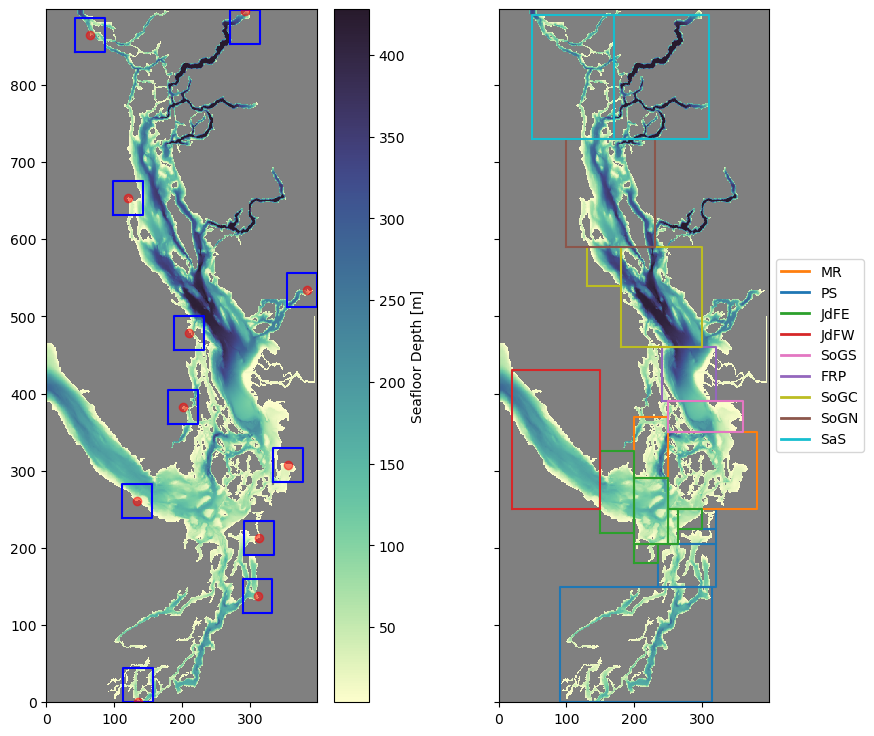

In [14]:
box_size = 22

fig, ax = plt.subplots(1, 2, figsize=(10, 9), sharey=True)
mycmap = cm.deep
mycmap.set_bad('grey')
colours = ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
cb = fig.colorbar(colours, ax=ax[0], label=r'{}'.format('Seafloor Depth [m]'))
viz_tools.set_aspect(ax[0]);

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
plot_box(ax[0], Nooksack, 'b')
plot_point('fraser', 'Nooksack', ax[0])

Skagit = river_box('skagit', 'Skagit1', box_size)
plot_box(ax[0], Skagit, 'b')
plot_point('skagit', 'Skagit1', ax[0])

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
plot_box(ax[0], Snohomish, 'b')
plot_point('skagit', 'SnohomishAllenQuilceda', ax[0])

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
plot_box(ax[0], Nisqually, 'b')
plot_point('puget', 'NisquallyMcAllister', ax[0])

Elwha = river_box('jdf', 'Elwha', box_size)
plot_box(ax[0], Elwha, 'b')
plot_point('jdf', 'Elwha', ax[0])

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
plot_box(ax[0], Cowichan, 'b')
plot_point('evi_s', 'Cowichan1', ax[0])

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
plot_box(ax[0], Nanaimo, 'b')
plot_point('evi_s', 'Nanaimo1', ax[0])

Puntledge = river_box('evi_s', 'Puntledge', box_size)
plot_box(ax[0], Puntledge, 'b')
plot_point('evi_s', 'Puntledge', ax[0])

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
plot_box(ax[0], Salmon, 'b')
plot_point('evi_n', 'SalmonSayward', ax[0])

Homathko = river_box('bute', 'Homathko', box_size)
plot_box(ax[0], Homathko, 'b')
plot_point('bute', 'Homathko', ax[0])

Squamish = river_box('howe', 'Squamish', box_size)
plot_box(ax[0], Squamish, 'b')
plot_point('howe', 'Squamish', ax[0])

boxcalls = [Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish]
boxnames = ['Nooksack', 'Skagit', 'Snohomish', 'Nisqually', 'Elwha', 'Cowichan', 'Nanaimo', 'Puntledge', 'Salmon', 'Homathko', 'Squamish']

## regions
tablist_nogrey = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
mycmap = cm.deep
mycmap.set_bad('grey')
colours = ax[1].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
# cb = fig.colorbar(colours, ax=ax[1], label=r'{}'.format('Seafloor Depth [m]'))
viz_tools.set_aspect(ax[1]);

## Puget Sound
PS_main = [0, 150, 90, 315]
plot_box(ax[1], PS_main, tablist_nogrey[0])
PS_AIWB = [150, 205, 235, 320]
plot_box(ax[1], PS_AIWB, tablist_nogrey[0])
PS_WB = [205, 225, 265, 320]
plot_box(ax[1], PS_WB, tablist_nogrey[0])
PS_DP = [225, 250, 300, 320]
plot_box(ax[1], PS_DP, tablist_nogrey[0])

# puget_sound_poly = shapely.geometry.Polygon([(85, 1), (220, 1), (325, 120), (325, 255), (310, 255), (240, 200), (235, 170), (100, 90)])
# plot_poly(ax[1], puget_sound_poly, 'k')

## Mixing Region
mixing_region1 = [290, 370, 200, 250]
plot_box(ax[1], mixing_region1, tablist_nogrey[1])
mixing_region2 = [250, 350, 250, 380]
plot_box(ax[1], mixing_region2, tablist_nogrey[1])

# mixing_region_poly = shapely.geometry.Polygon([(200, 300), (340, 245), (390, 330), (200, 350)])
# plot_poly(ax[1], mixing_region_poly, 'b')

## Juan de Fuca
JdF2 = [220, 325, 150, 200]
plot_box(ax[1], JdF2, tablist_nogrey[2])
JdF3 = [205, 290, 200, 250]
plot_box(ax[1], JdF3, tablist_nogrey[2])
JdF4 = [180, 205, 200, 235]
plot_box(ax[1], JdF4, tablist_nogrey[2])
JdF5 = [205, 250, 250, 265]
plot_box(ax[1], JdF5, tablist_nogrey[2])
JdF6 = [225, 250, 265, 300]
plot_box(ax[1], JdF6, tablist_nogrey[2])
JdF1 = [250, 430, 20, 150]
plot_box(ax[1], JdF1, tablist_nogrey[3])  ## West


## Fraser River Plume
Fraser_plume = [390, 460, 240, 320]
plot_box(ax[1], Fraser_plume, tablist_nogrey[4])

## Strait of Georgia
SoG_south = [350, 390, 250, 360]
plot_box(ax[1], SoG_south, tablist_nogrey[6])
SoG_center1 = [460, 590, 180, 300]
plot_box(ax[1], SoG_center1, tablist_nogrey[7])
SoG_center2 = [540, 590, 130, 180]
plot_box(ax[1], SoG_center2, tablist_nogrey[7])
SoG_north = [590, 730, 100, 230]
plot_box(ax[1], SoG_north, tablist_nogrey[5])

## Northern Sounds
sounds = [730, 890, 170, 310]
plot_box(ax[1], sounds, tablist_nogrey[8])
straits = [730, 890, 50, 170]
plot_box(ax[1], straits, tablist_nogrey[8])

region_colors_dict = {'PS':tablist_nogrey[0], 'MR':tablist_nogrey[1], 'JdFW':tablist_nogrey[3], 'JdFE':tablist_nogrey[2], 'FRP':tablist_nogrey[4], 'SoGS':tablist_nogrey[6], 
                      'SoGC':tablist_nogrey[7], 'SoGN':tablist_nogrey[5], 'SaS':tablist_nogrey[8]
}

# order wanted: MR, PS, JdFE, JdFW, SoGS, FRP, SoGC, SoGN, SaS
custom_lines = [
    plt.Line2D([0], [0], color=region_colors_dict['MR'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['PS'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['JdFE'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['JdFW'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['SoGS'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['FRP'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['SoGC'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['SoGN'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['SaS'], lw=2, linestyle='-')
]
plt.legend(custom_lines, list(['MR', 'PS', 'JdFE', 'JdFW', 'SoGS', 'FRP', 'SoGC', 'SoGN', 'SaS']), loc='center left', bbox_to_anchor=(1, 0.5))

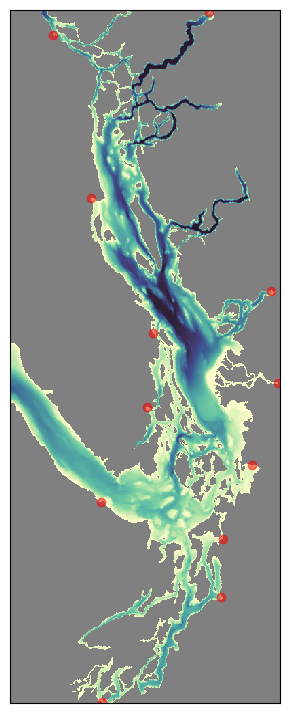

In [24]:
box_size = 22

fig, ax = plt.subplots(1, 1, figsize=(5, 9), sharey=True)
mycmap = cm.deep
mycmap.set_bad('grey')
colours = ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
# cb = fig.colorbar(colours, ax=ax, label=r'{}'.format('Seafloor Depth [m]'))
viz_tools.set_aspect(ax);
ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
#plot_box(ax, Nooksack, 'b')
plot_point('fraser', 'Nooksack', ax)

Skagit = river_box('skagit', 'Skagit1', box_size)
#plot_box(ax, Skagit, 'b')
plot_point('skagit', 'Skagit1', ax)

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
#plot_box(ax, Snohomish, 'b')
plot_point('skagit', 'SnohomishAllenQuilceda', ax)

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
#plot_box(ax, Nisqually, 'b')
plot_point('puget', 'NisquallyMcAllister', ax)

Elwha = river_box('jdf', 'Elwha', box_size)
#plot_box(ax, Elwha, 'b')
plot_point('jdf', 'Elwha', ax)

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
#plot_box(ax, Cowichan, 'b')
plot_point('evi_s', 'Cowichan1', ax)

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
#plot_box(ax, Nanaimo, 'b')
plot_point('evi_s', 'Nanaimo1', ax)

Puntledge = river_box('evi_s', 'Puntledge', box_size)
#plot_box(ax, Puntledge, 'b')
plot_point('evi_s', 'Puntledge', ax)

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
#plot_box(ax, Salmon, 'b')
plot_point('evi_n', 'SalmonSayward', ax)

Homathko = river_box('bute', 'Homathko', box_size)
#plot_box(ax, Homathko, 'b')
plot_point('bute', 'Homathko', ax)

Squamish = river_box('howe', 'Squamish', box_size)
#plot_box(ax, Squamish, 'b')
plot_point('howe', 'Squamish', ax)

river_idx = [rivers.prop_dict['fraser']['Fraser']['i'], rivers.prop_dict['fraser']['Fraser']['j']]
ax.plot(river_idx[1], river_idx[0]-85, 'ro', alpha=0.5)

Nooksack


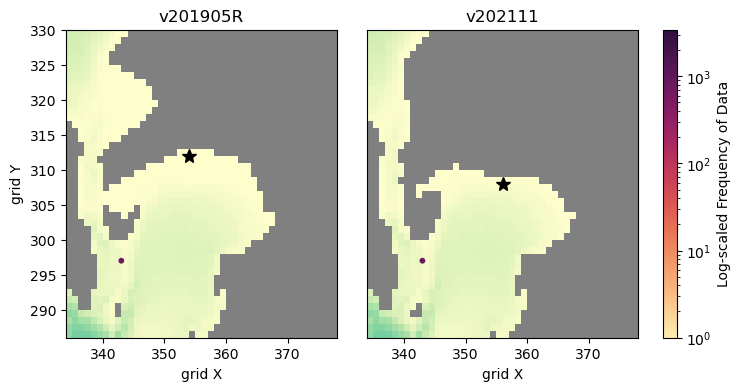

Skagit


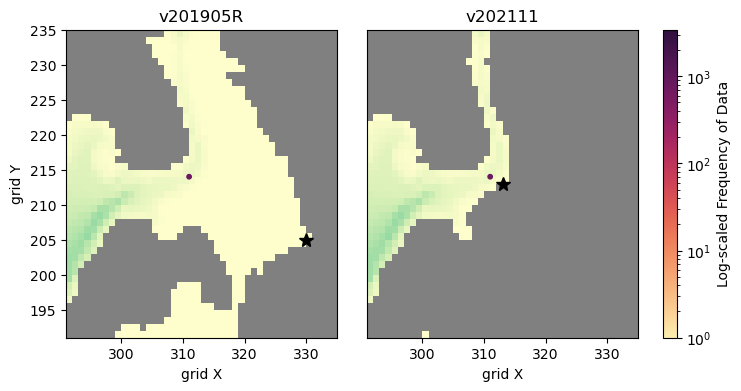

Snohomish


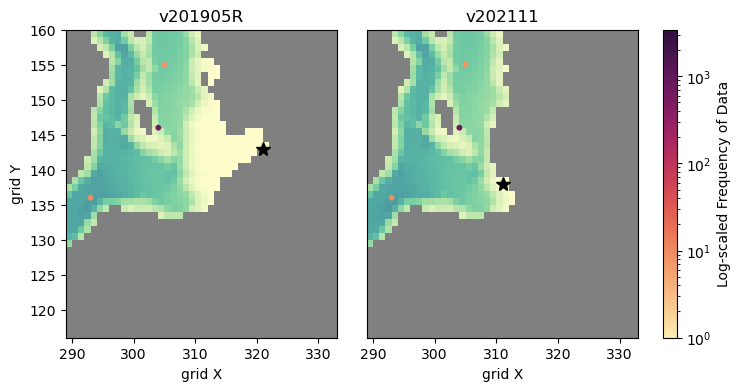

Nisqually


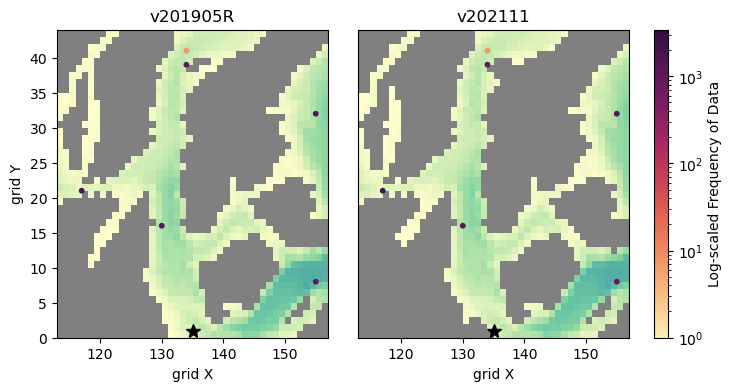

Elwha


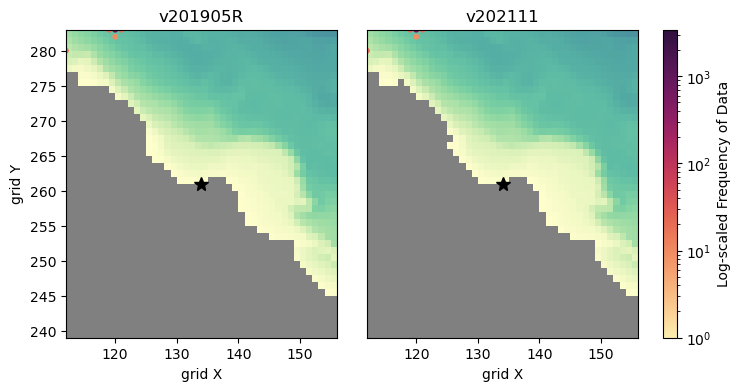

Cowichan


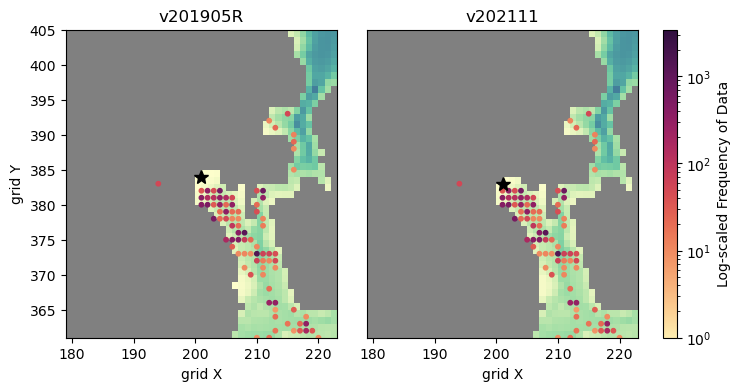

Nanaimo


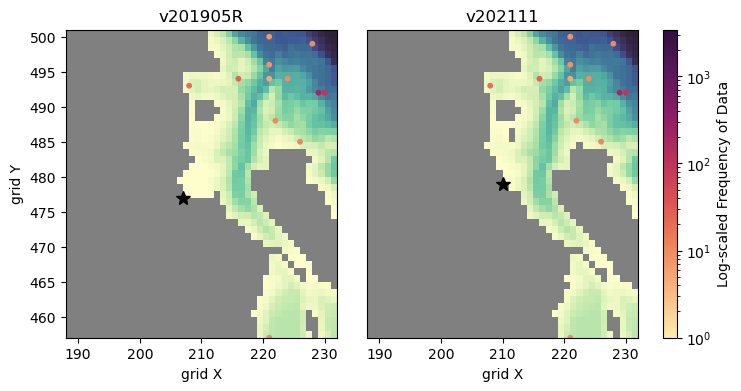

Puntledge


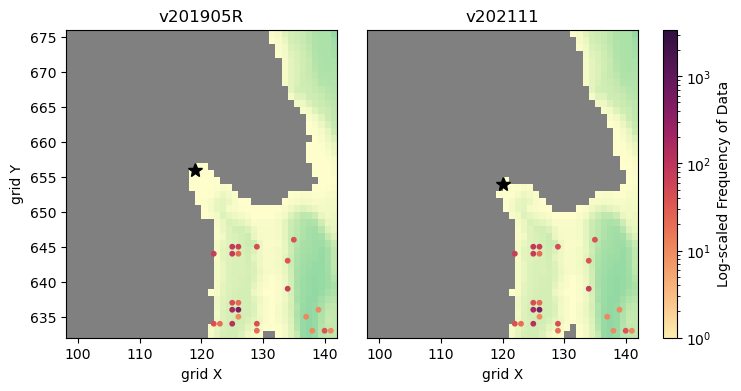

Salmon


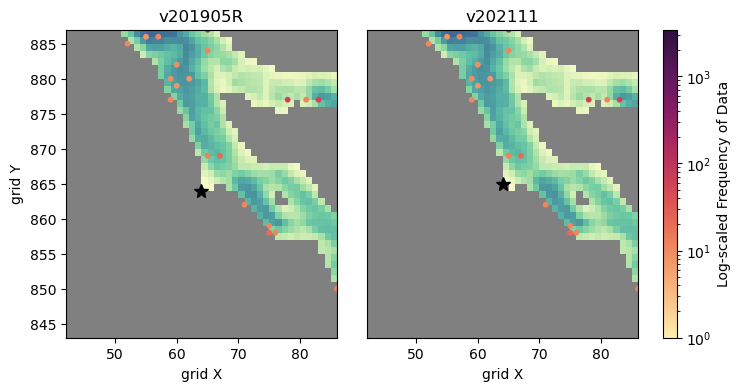

Homathko


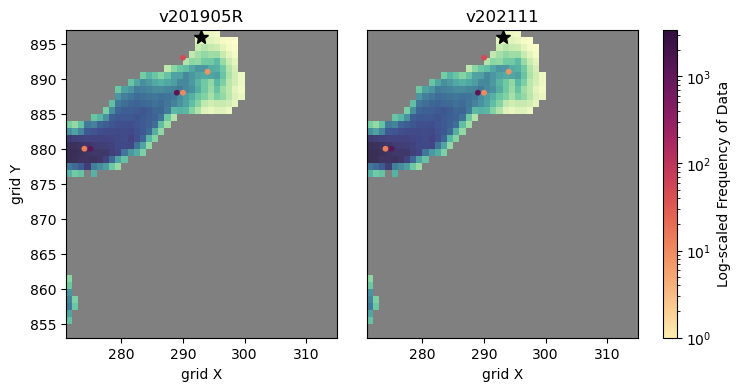

Squamish


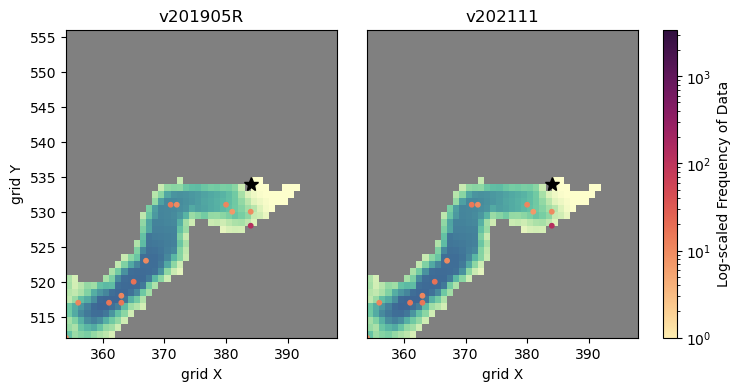

In [114]:
for boxname,boxcall in zip(boxnames,boxcalls):
    plot_bathy_and_data2(boxcall, boxname)

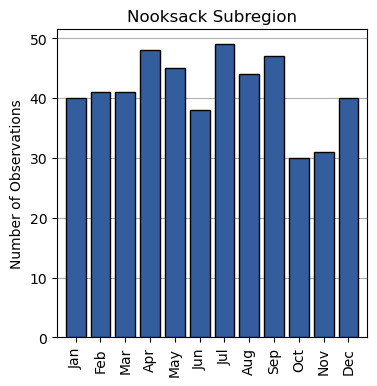

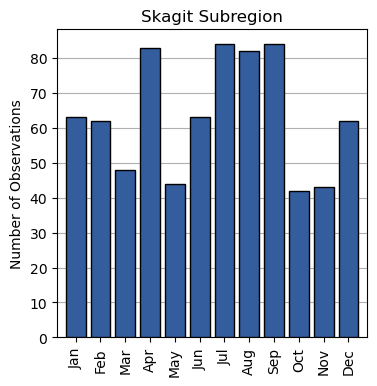

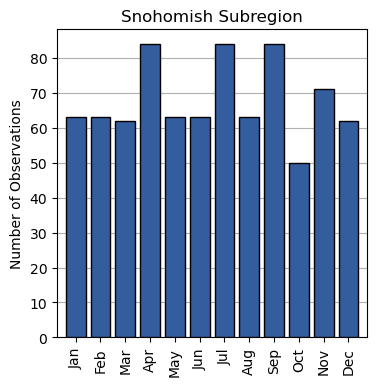

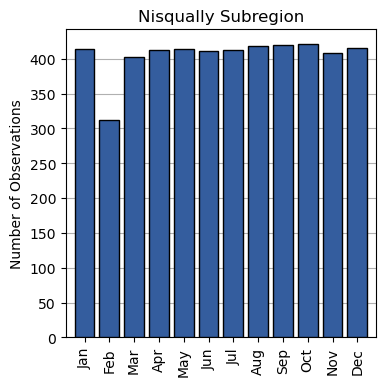

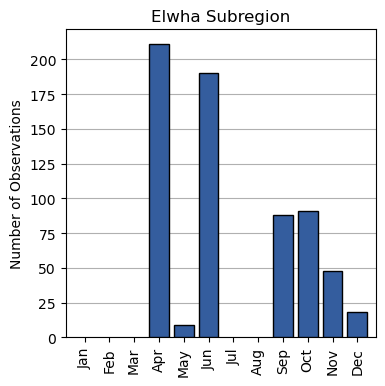

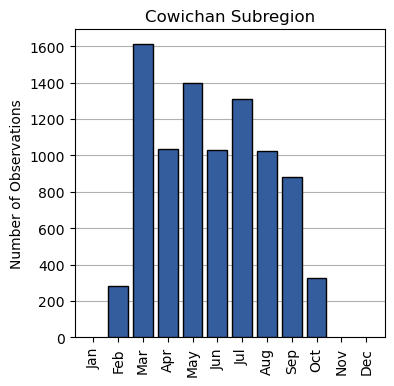

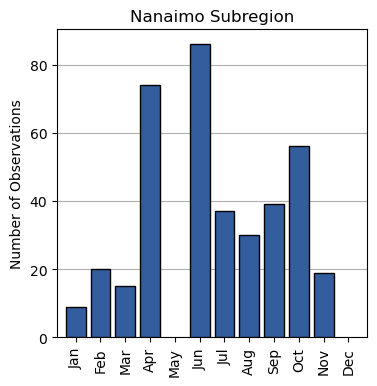

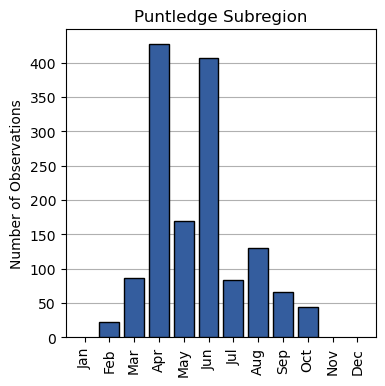

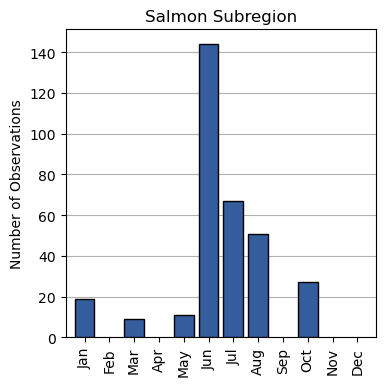

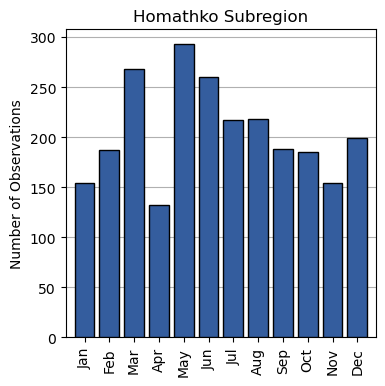

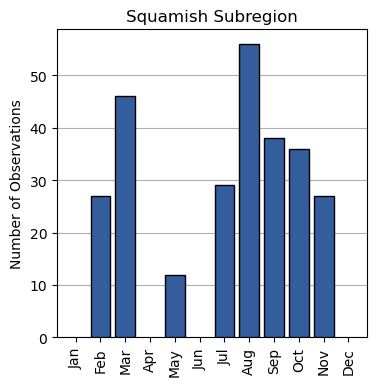

In [195]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
all_months = pd.DataFrame({'Month': range(1, 13)})

for idx in np.arange(len(boxcalls)):
    fig, ax = plt.subplots(1,1, figsize=(4,4))

    select = temp1[(temp1.k >= 0) & (temp1.k <= 10) &
                        (temp1.j >= boxcalls[idx][0]) & (temp1.j <= boxcalls[idx][1]) &
                        (temp1.i >= boxcalls[idx][2]) & (temp1.i <= boxcalls[idx][3])]
    months_df = select.groupby(['Month']).size().reset_index(name='count')
    merged_df = pd.merge(all_months, months_df, on='Month', how='left')
    merged_df['count'] = merged_df['count'].fillna(0)
    merged_df['count'] = merged_df['count'].astype(int)
    ax.grid(axis='y', which='major', zorder=0)
    ax.bar(months_df['Month'], months_df['count'], color=color3, edgecolor='k', zorder=3)
    ax.set_xlim([0.25,12.75])
    ax.set_title('{} Subregion'.format(boxnames[idx]))
    ax.set_xticks(all_months['Month'].values)
    ax.set_xticklabels(months, rotation=90)
    ax.set_ylabel('Number of Observations')